# Challenge: Model Comparison

In this exercise, we will compare the accuracy of two regression models on a single dataset: an OLS regression and a KNN regression. The data are drawn from Weather Underground's [What 12 Months Of Record-Setting Temperatures Looks Like Across The U.S.](http://fivethirtyeight.com/features/what-12-months-of-record-setting-temperatures-looks-like-across-the-u-s/), which compiled historical weather data from 1880 to 2014. We will focus on temperature and precipitation data for New York City. 

In [56]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format
import seaborn as sns
import scipy.stats as stats
sns.set_style("whitegrid")

import math
from math import sqrt

from IPython.display import display

import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA 
from sklearn import linear_model
from sklearn import neighbors

from sklearn.pipeline import Pipeline

from sklearn.cross_validation import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error


# Suppress annoying harmless error.
import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

Let's load the data, and get a sense for how it is structured.

In [57]:
#Read in the data.
weather = pd.read_csv('/Users/teresaoneill/Dropbox/Thinkful/Datasets/KNYC.csv')
print(len(weather))
weather.head()
print(weather.describe())

365
       actual_mean_temp  actual_min_temp  actual_max_temp  average_min_temp  \
count           365.000          365.000          365.000           365.000   
mean             54.737           47.247           61.734            48.016   
std              18.680           18.277           19.447            14.749   
min              11.000            2.000           19.000            27.000   
25%              39.000           34.000           44.000            34.000   
50%              58.000           50.000           65.000            48.000   
75%              72.000           64.000           80.000            63.000   
max              85.000           77.000           92.000            69.000   

       average_max_temp  record_min_temp  record_max_temp  \
count           365.000          365.000          365.000   
mean             62.079           28.244           83.732   
std              16.069           20.729           13.351   
min              38.000          -15.000

From the descriptions above, it appears that there are no missing datapoints. Most of our features are continuous, measuring temperature and precipitation. The dataset also includes two categorical features, which indicate the years in which the record minimum and maximum temperatures occurred for each date. For this exercise, we will focus only on the continuous features.

Let's prepare our data for modeling, selecting actual mean temperature as our dependent variable. 

## Data exploration and feature selection

/Users/teresaoneill/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


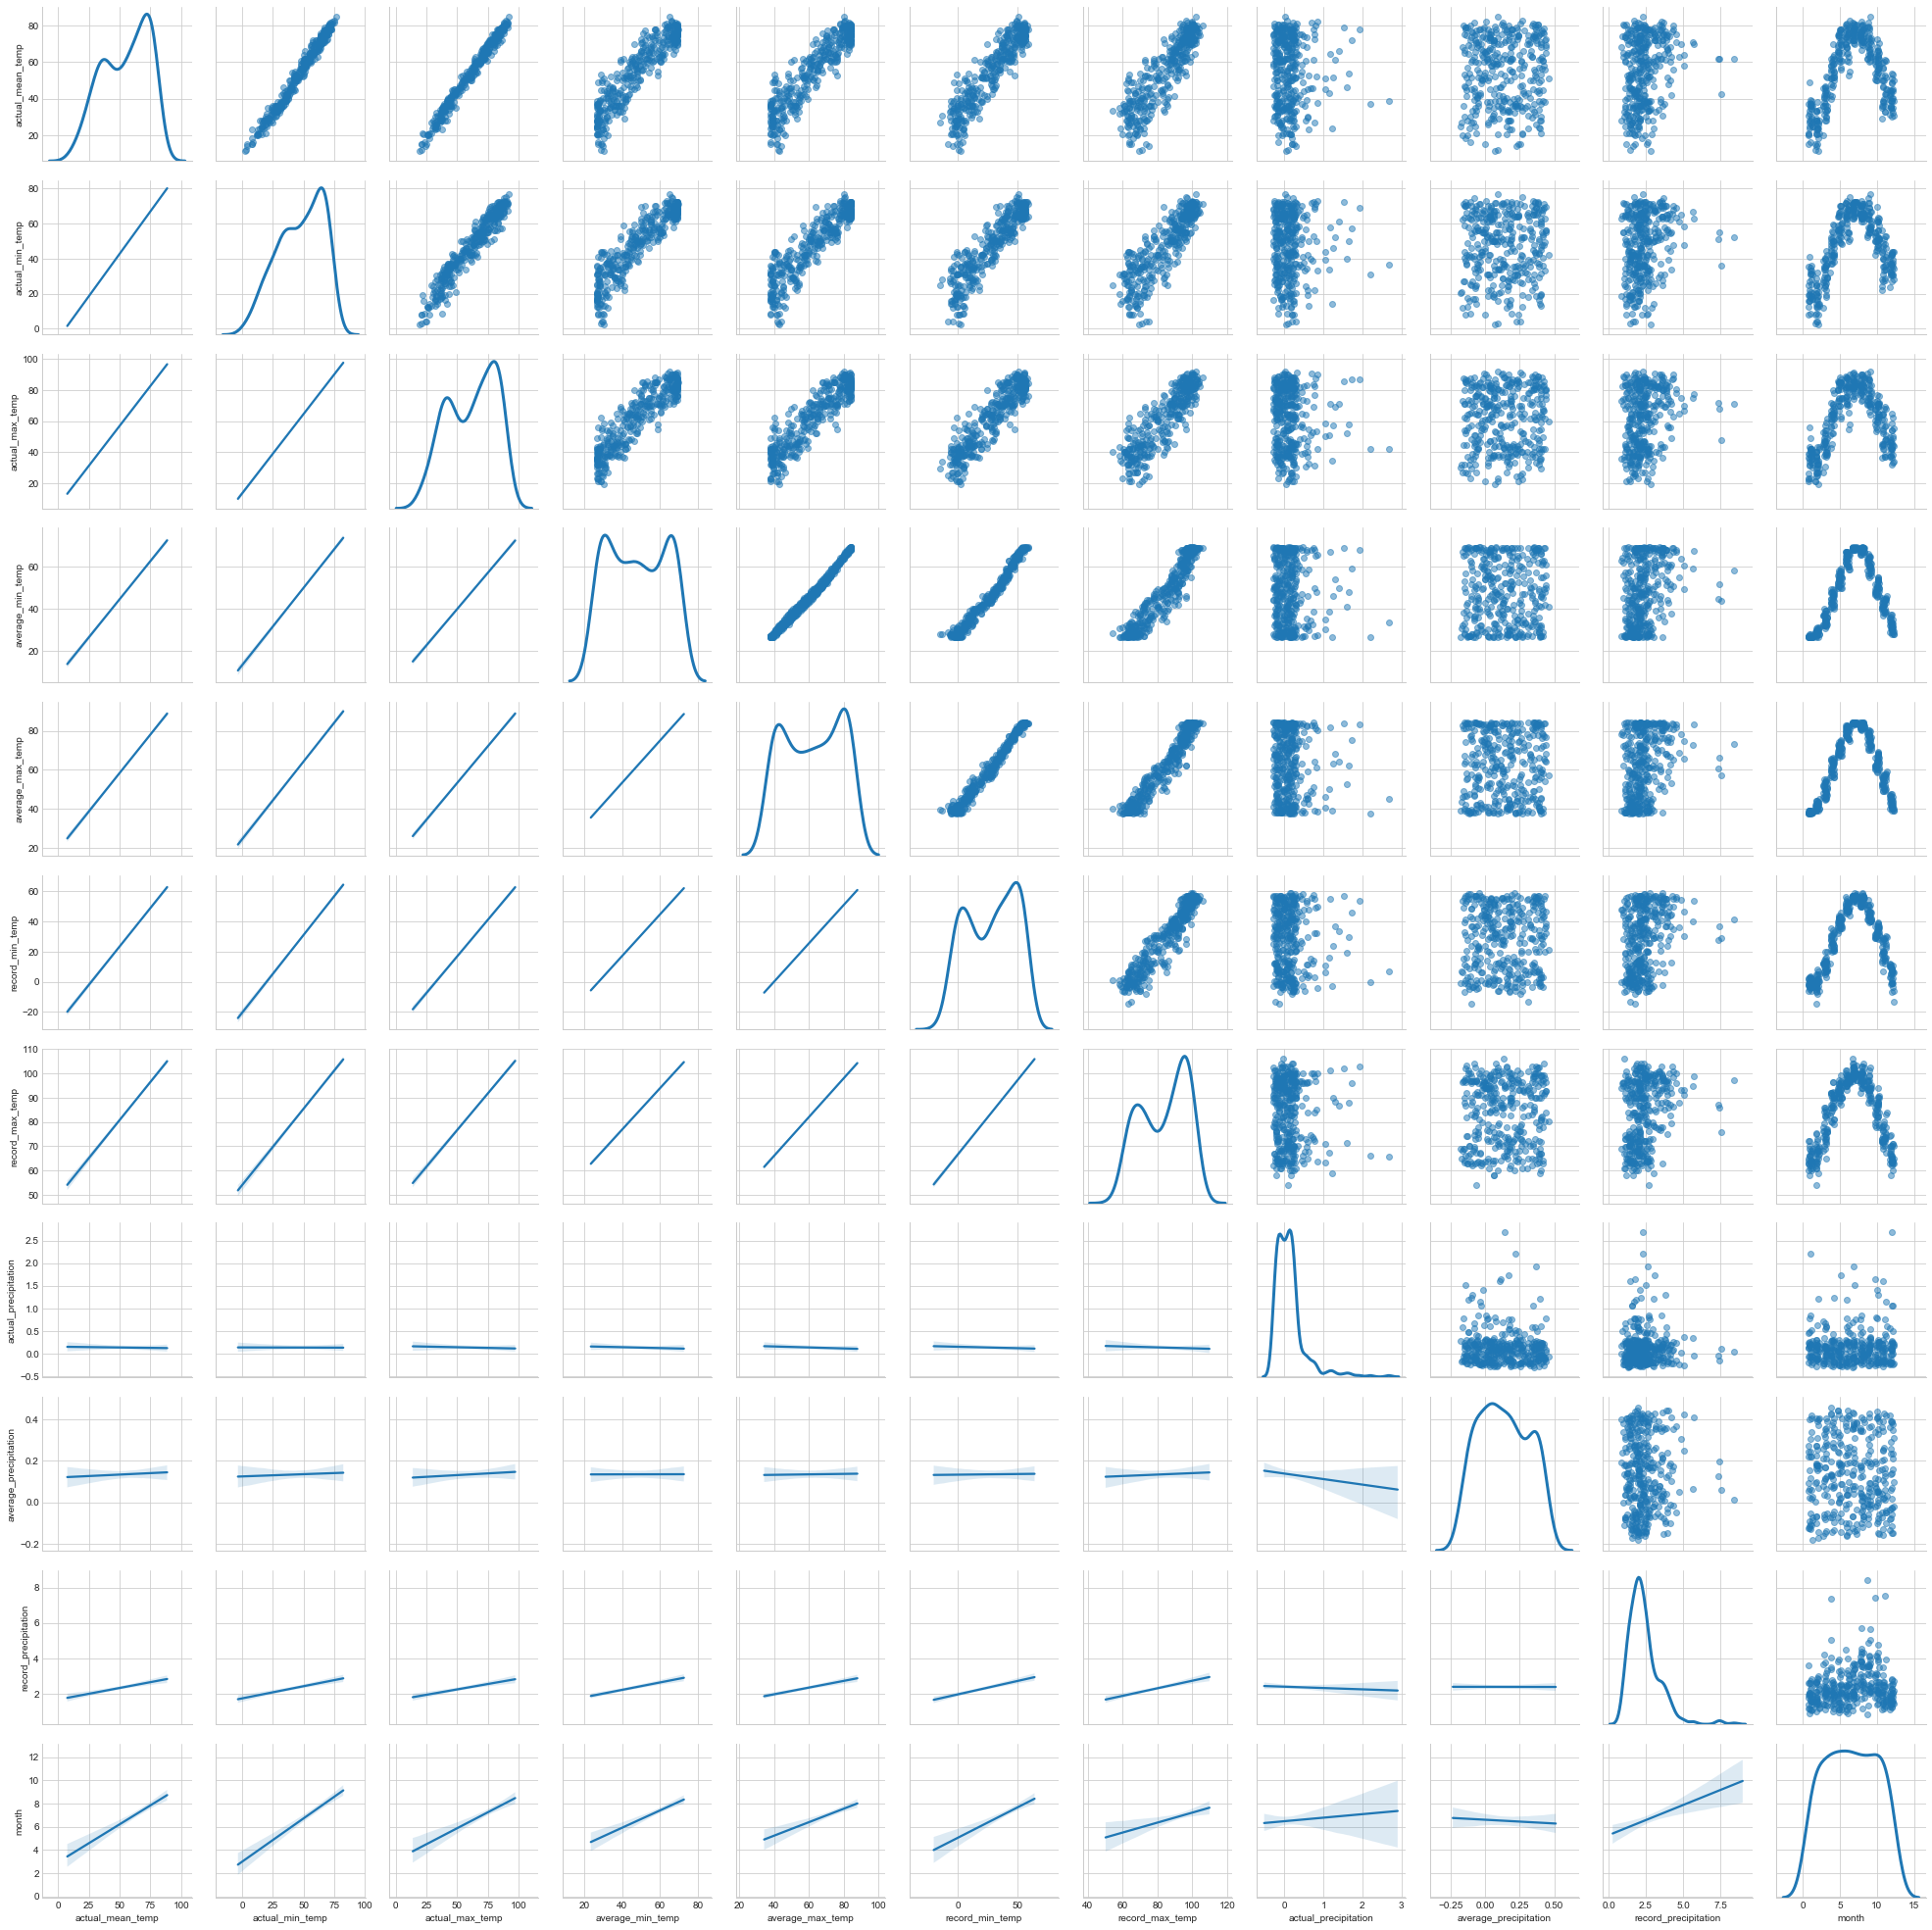

In [58]:
#Drop the categorical columns, which we will not use in this exercise.
weather1 = weather.drop(['record_min_temp_year', 'record_max_temp_year'], axis=1)

weather1['date'] = pd.to_datetime(weather1['date'])
weather1['month'] = weather1['date'].dt.month

#Use the date as index.
#weather1.set_index('date', drop=True, inplace=True)

#Visualize the distributions and relationships among the continuous variables.

# Make a copy of the data to add jitter to and plot.
weather1_jittered = weather1.loc[:,'actual_mean_temp':]

# Make the random noise.
jitter = pd.DataFrame(
    np.random.uniform(-.3, .3, size=(weather1_jittered.shape)),
    columns=weather1_jittered.columns
)

# Combine the data and the noise.

weather1_jittered = weather1_jittered.add(jitter)
#Declare the plot and plot.
g = sns.PairGrid(weather1_jittered, diag_sharey=False)
g.map_upper(plt.scatter, alpha=.5)

# Fit line summarizing the linear relationship of the two variables.
g.map_lower(sns.regplot, scatter_kws=dict(alpha=0))

# Give information about the univariate distributions of the variables.
g.map_diag(sns.kdeplot, lw=3)
plt.show()

                       actual_mean_temp  actual_min_temp  actual_max_temp  \
actual_mean_temp                  1.000            0.990            0.992   
actual_min_temp                   0.990            1.000            0.965   
actual_max_temp                   0.992            0.965            1.000   
average_min_temp                  0.916            0.910            0.906   
average_max_temp                  0.917            0.907            0.911   
record_min_temp                   0.920            0.912            0.912   
record_max_temp                   0.878            0.862            0.879   
actual_precipitation             -0.014            0.001           -0.028   
average_precipitation             0.528            0.534            0.515   
record_precipitation              0.229            0.234            0.222   
month                             0.352            0.394            0.308   

                       average_min_temp  average_max_temp  record_min_temp 

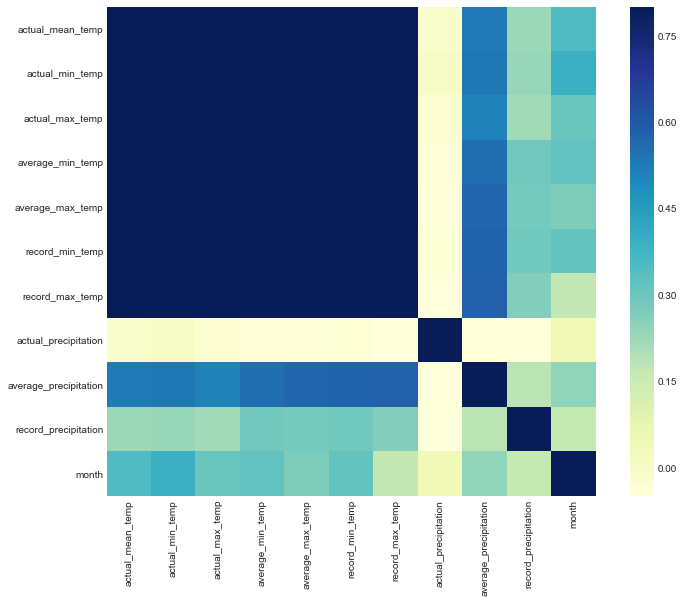

In [59]:
# Make the correlation matrix.
corrmat = weather1.corr()
print(corrmat)

# Set up the matplotlib figure.
f, ax = plt.subplots(figsize=(12, 9))

# Draw the heatmap using seaborn.
sns.heatmap(corrmat, vmax=.8, square=True, cmap="YlGnBu")
plt.show()

We can see in the kde plots on the diagonal that our temperature variables have bimodal normal distributions. If our models are weak in certain areas, this is something to keep an eye on. The plots above also suggest that historical precipitation data has more right-skew than the temperature data, so we'll check for outliers before moving on. Furthermore, we can see a consistent relationship between temperature and date; since date is categorical, this is not a linear relationship.

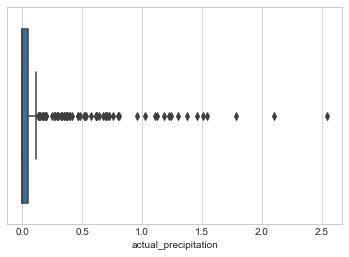

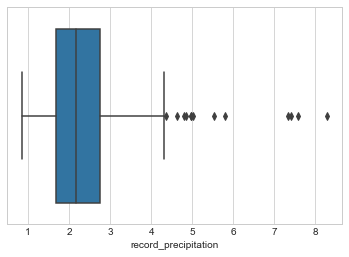

In [60]:
sns.boxplot(weather1['actual_precipitation'])
plt.show()

sns.boxplot(weather1['record_precipitation'])
plt.show()

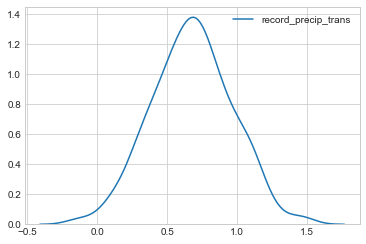

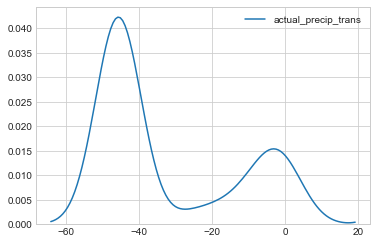

In [61]:
#Log-transform precip variables, after adding a small constant (so there are no more zeros).

weather1['record_precipitation_const'] = weather1['record_precipitation'].apply(lambda x: x+0.01)
weather1['record_precip_trans'] = stats.boxcox(weather1['record_precipitation_const'])[0]

weather1['actual_precipitation_const'] = weather1['actual_precipitation'].apply(lambda x: x+0.01)
weather1['actual_precip_trans'] = stats.boxcox(weather1['actual_precipitation_const'])[0]
weather1 = weather1.drop(['record_precipitation_const', 'actual_precipitation_const'], axis=1)

sns.kdeplot(weather1['record_precip_trans'])
plt.show()

sns.kdeplot(weather1['actual_precip_trans'])
plt.show()

                       actual_mean_temp  actual_min_temp  actual_max_temp  \
actual_mean_temp                  1.000            0.990            0.992   
actual_min_temp                   0.990            1.000            0.965   
actual_max_temp                   0.992            0.965            1.000   
average_min_temp                  0.916            0.910            0.906   
average_max_temp                  0.917            0.907            0.911   
record_min_temp                   0.920            0.912            0.912   
record_max_temp                   0.878            0.862            0.879   
actual_precipitation             -0.014            0.001           -0.028   
average_precipitation             0.528            0.534            0.515   
record_precipitation              0.229            0.234            0.222   
month                             0.352            0.394            0.308   
record_precip_trans               0.222            0.233            0.210   

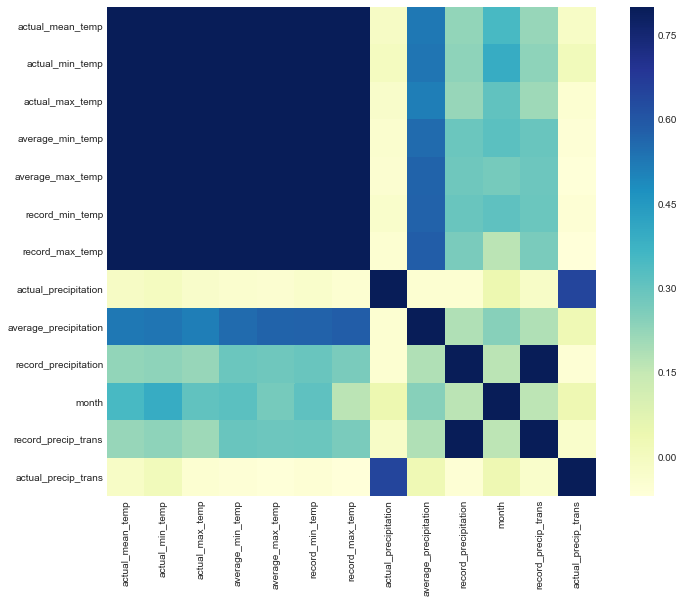

In [62]:
# Make the correlation matrix.
corrmat = weather1.corr()
print(corrmat)

# Set up the matplotlib figure.
f, ax = plt.subplots(figsize=(12, 9))

# Draw the heatmap using seaborn.
sns.heatmap(corrmat, vmax=.8, square=True, cmap="YlGnBu")
plt.show()

Before we model, let's reduce some dimensionality in our feature space using PCA, anticipating collinearity issues.

We can also observe that the transformed precipitation features and the original features correlate consistently with our out come variable, so only the transformed features will be used in modeling.

Covariance Matrix:
 [[ 1.00274725  0.96720707  0.912563    0.90928772  0.91477186  0.86432604]
 [ 0.96720707  1.00274725  0.90858224  0.91368937  0.91462347  0.88110493]
 [ 0.912563    0.90858224  1.00274725  0.99850632  0.98997219  0.94734162]
 [ 0.90928772  0.91368937  0.99850632  1.00274725  0.99085234  0.96457983]
 [ 0.91477186  0.91462347  0.98997219  0.99085234  1.00274725  0.94469727]
 [ 0.86432604  0.88110493  0.94734162  0.96457983  0.94469727  1.00274725]]
The percentage of total variance in the dataset explained by each component from Sklearn PCA.
 [  9.43779620e-01   3.59547562e-02   1.20424717e-02   5.46437878e-03
   2.38256801e-03   3.76205185e-04]


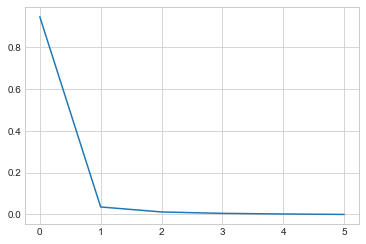

In [63]:
#Select the two variables.
temps = weather1.loc[:, 'actual_min_temp':'record_max_temp']

#Normalize the variables.
X = StandardScaler().fit_transform(temps)

# Transpose X.
Xt = X.T
Cx = np.cov(Xt)
print('Covariance Matrix:\n', Cx)

#Run PCA analysis on the two variables
sklearn_pca = PCA(n_components=6)
Y_sklearn = sklearn_pca.fit_transform(X)

print(
    'The percentage of total variance in the dataset explained by each',
    'component from Sklearn PCA.\n',
    sklearn_pca.explained_variance_ratio_
)

plt.plot(sklearn_pca.explained_variance_ratio_)
plt.show()
weather1['temps'] = Y_sklearn[:, 0]

Taking just the first component, we can reduce our feature space from 6 features to 1 component, accounting for 94.4% of the variance of the original features. We're now ready to run our first OLS model.

## OLS Model 1

In [64]:
# Instantiate and fit our model.

#Use the smf.ols to generate summary table.
linear_formula = 'actual_mean_temp ~ temps+actual_precip_trans+average_precipitation+record_precip_trans'

# Fit the model to our data using the formula.
lm = smf.ols(formula=linear_formula, data=weather1).fit()

# Inspect the results.
print(lm.summary())

#Use LinearRegression() so we can set our X and Y and get access to the predictions.
regr = linear_model.LinearRegression()
Y = weather1['actual_mean_temp']
X = weather1[['temps', 'actual_precip_trans','average_precipitation','record_precip_trans']]
regr.fit(X, Y)

# Extract predicted values.
predicted = regr.predict(X).ravel()
actual = Y

mse = mean_squared_error(actual, predicted)
print(mse)

                            OLS Regression Results                            
Dep. Variable:       actual_mean_temp   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                     1193.
Date:                Fri, 27 Oct 2017   Prob (F-statistic):          3.45e-206
Time:                        17:30:48   Log-Likelihood:                -1101.1
No. Observations:                 365   AIC:                             2212.
Df Residuals:                     360   BIC:                             2232.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                62.94

In this overfitted model, we have a pretty mean square error rate, a strong R squared value, and all our features except for average_precipitation are significant (and even this feature is borderline). We might have a little trouble with multicollinearity, but the culprit is likely average_precipitation, which we will try dropping anyway. 

Let's cross-validate across five folds. 

In [65]:
score = cross_val_score(regr, X, Y, cv=5, scoring='neg_mean_squared_error')
print("Scores for OLS model: {}".format(score))
print("Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

Scores for OLS model: [-16.7638171  -20.3087211  -55.62816472 -46.03451393 -22.71102178]
Accuracy: -32.29 (+/- 31.11)


Our average mean square error across the folds is 32.29, with a variance of 31.11.

- **Question: Why does 'scoring' require 'neg_mean_squared_error' instead of 'mean_squared_error'?**
- **Question: What is ithe best scoring metric to use?**

Let's confirm that we're satisfying the assumptions of linear regression before we move on and test the KNN model.

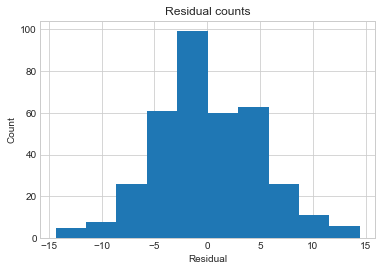

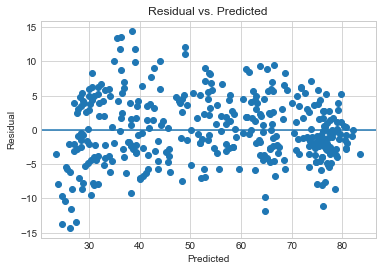

In [66]:
# Calculate the residual error.
residual = actual - predicted

#Check multivariate normality.
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

#Check homoscedasticity.
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

The residuals are distributed quite normally, and there isn't too much heteroscedasticity; however, the lowest estimates tend to underestimate, so we will come back to that later.

- **Question: What do you recommend for dealing with the bimodal normal distribution in our data? Could that help with the heteroscedasticity?**

## KNN Model 1

In [67]:
#Instantiate a KNN model.

knn_1 = neighbors.KNeighborsRegressor(n_neighbors=5)

#Fit the model with X and Y as defined above.
knn_1.fit(X, Y)

predicted = knn_1.predict(X).ravel()
actual = Y

mse = mean_squared_error(actual, predicted)
print(mse)

score = cross_val_score(knn_1, X, Y, cv=5, scoring='neg_mean_squared_error')
print("Scores for KNN model: {}".format(score))
print("Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

21.706739726
Scores for KNN model: [-34.48054795 -20.90849315 -84.7090411  -75.61808219 -43.77424658]
Accuracy: -51.90 (+/- 48.74)


Our KNN model is not performing quite as well, or as consistently, as our OLS model, according to mean squared error scores. 

## Tuning and iterating

Let's add weights to our KNN model, and see if it performs any better.

In [68]:
#Instantiate a KNN model.

knn_2 = neighbors.KNeighborsRegressor(n_neighbors=5, weights='distance')
knn_2.fit(X, Y)

score = cross_val_score(knn_2, X, Y, cv=5, scoring='neg_mean_squared_error')
print("Scores for KNN model: {}".format(score))
print("Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

Scores for KNN model: [-24.92045767 -23.30891361 -81.06820283 -56.94650104 -34.28031577]
Accuracy: -44.10 (+/- 44.07)


This model is a bit better than the first KNN model, but it is still not as successful as the OLS model. Next, we will drop average precipitation (which was not significant), and refit both models.

In [69]:
# Instantiate and fit our model.

#Use the smf.ols to generate summary table.
linear_formula = 'actual_mean_temp ~ temps+actual_precip_trans+record_precip_trans'

# Fit the model to our data using the formula.
lm2 = smf.ols(formula=linear_formula, data=weather1).fit()

# Inspect the results.
print(lm2.summary())

#Refit regr so we can get predicted values.
regr = linear_model.LinearRegression()
Y = weather1['actual_mean_temp']
X2 = weather1[['temps', 'actual_precip_trans','record_precip_trans']]
regr.fit(X2, Y)

# Extract predicted values.
predicted = regr.predict(X2).ravel()
actual = Y

mse = mean_squared_error(actual, predicted)
print(mse)

score = cross_val_score(regr, X2, Y, cv=5, scoring='neg_mean_squared_error')
print("Scores for OLS model: {}".format(score))
print("Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

                            OLS Regression Results                            
Dep. Variable:       actual_mean_temp   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.928
Method:                 Least Squares   F-statistic:                     1576.
Date:                Fri, 27 Oct 2017   Prob (F-statistic):          5.44e-207
Time:                        17:30:49   Log-Likelihood:                -1103.0
No. Observations:                 365   AIC:                             2214.
Df Residuals:                     361   BIC:                             2230.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              57.4826    

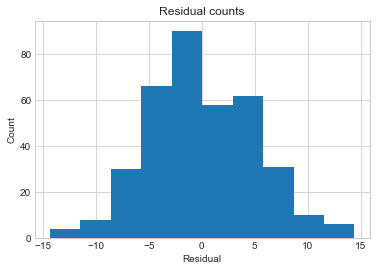

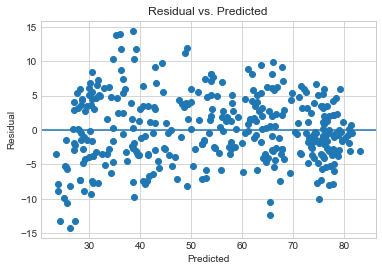

In [70]:
# Calculate the residual error.
residual = actual - predicted

#Check multivariate normality.
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

#Check homoscedasticity.
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

This iteration of our OLS model does not improve upon the first one. Let's check whether dropping average precipitation improves the KNN model.

In [71]:
#Instantiate a KNN model.
knn_3 = neighbors.KNeighborsRegressor(n_neighbors=5, weights='distance')
knn_3.fit(X2, Y)

score = cross_val_score(knn_3, X2, Y, cv=5, scoring='neg_mean_squared_error')
print("Scores for KNN model: {}".format(score))
print("Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

Scores for KNN model: [-25.00491573 -23.34929698 -81.03082199 -56.9796816  -34.29355119]
Accuracy: -44.13 (+/- 44.01)


The difference in performance is negligible. 

In [72]:
#Add month.

X3 = weather1[['temps', 'month', 'actual_precip_trans','record_precip_trans']]

knn_4 = neighbors.KNeighborsRegressor(n_neighbors=5, weights='distance')
knn_4.fit(X3, Y)

predicted_knn4 = knn_4.predict(X3).ravel()
actual = Y

score = cross_val_score(knn_4, X3, Y, cv=5, scoring='neg_mean_squared_error')
print("Scores for KNN model: {}".format(score))
print("Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

Scores for KNN model: [-69.96112189 -47.98392342 -89.36201989 -70.50011601 -64.15334391]
Accuracy: -68.39 (+/- 26.55)


Adding month, where months are treated as continuous variables, makes the model much less accurate. 

One more feature I'd like to try in our OLS model is a binary feature indicating whether or not there is precitipation, since there's a large number of zeros in the original dataset.

In [73]:
#Code a binary feature for precipitation
weather1['precip'] = np.where(weather['actual_precipitation']>0, 1, 0)

In [74]:
# Instantiate and fit our model.

#Use the smf.ols to generate summary table.
linear_formula = 'actual_mean_temp ~ temps+actual_precip_trans+record_precip_trans+precip'

# Fit the model to our data using the formula.
lm3 = smf.ols(formula=linear_formula, data=weather1).fit()

# Inspect the results.
print(lm3.summary())

#Refit regr so we can get predicted values.
regr = linear_model.LinearRegression()
Y = weather1['actual_mean_temp']
X4 = weather1[['temps', 'precip','actual_precip_trans','record_precip_trans']]
regr.fit(X4, Y)

# Extract predicted values.
predicted = regr.predict(X4).ravel()
actual = Y

mse = mean_squared_error(actual, predicted)
print(mse)

score = cross_val_score(regr, X4, Y, cv=5, scoring='neg_mean_squared_error')
print("Scores for OLS model: {}".format(score))
print("Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

                            OLS Regression Results                            
Dep. Variable:       actual_mean_temp   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.930
Method:                 Least Squares   F-statistic:                     1202.
Date:                Fri, 27 Oct 2017   Prob (F-statistic):          9.38e-207
Time:                        17:30:49   Log-Likelihood:                -1099.7
No. Observations:                 365   AIC:                             2209.
Df Residuals:                     360   BIC:                             2229.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              51.0730    

In [75]:
# Finally, add 'month'.

#Use the smf.ols to generate summary table.
linear_formula = 'actual_mean_temp ~ temps+month+actual_precip_trans+record_precip_trans+precip'

# Fit the model to our data using the formula.
lm4 = smf.ols(formula=linear_formula, data=weather1).fit()

# Inspect the results.
print(lm4.summary())

#Refit regr so we can get predicted values.
regr = linear_model.LinearRegression()
Y = weather1['actual_mean_temp']
X5 = weather1[['temps', 'month','precip','actual_precip_trans','record_precip_trans']]
regr.fit(X5, Y)

# Extract predicted values.
predicted_ols5 = regr.predict(X5).ravel()
actual = Y

mse = mean_squared_error(actual, predicted_ols5)
print(mse)

score = cross_val_score(regr, X5, Y, cv=5, scoring='neg_mean_squared_error')
print("Scores for OLS model: {}".format(score))
print("Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

                            OLS Regression Results                            
Dep. Variable:       actual_mean_temp   R-squared:                       0.935
Model:                            OLS   Adj. R-squared:                  0.934
Method:                 Least Squares   F-statistic:                     1025.
Date:                Fri, 27 Oct 2017   Prob (F-statistic):          5.14e-210
Time:                        17:30:49   Log-Likelihood:                -1088.4
No. Observations:                 365   AIC:                             2189.
Df Residuals:                     359   BIC:                             2212.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              48.8049    

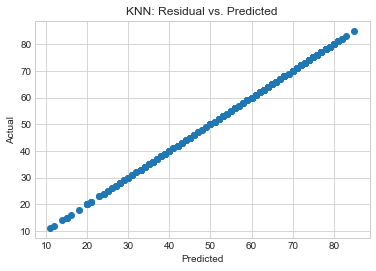

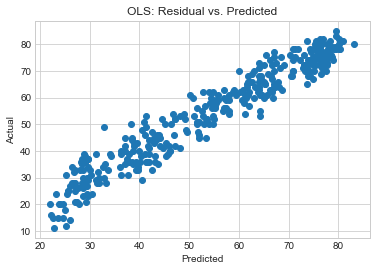

In [76]:
#Visualize the predictions of our final models of each type.
#QUESTION! WHY IS THE PLOT SO PERFECTLY LINEAR FOR KNN?

plt.scatter(predicted_knn4, actual)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('KNN: Residual vs. Predicted')
plt.show()

plt.scatter(predicted_ols5, actual)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('OLS: Residual vs. Predicted')
plt.show()

Although the precip feature is significant, there's no improvement on the RME or variance. The addition of month, however, improves the RME a bit, and decreases variance in crossvalidation. 

We'll now assess the strengths and weaknesses of the two types of regression model.

## Comparison 

For this dataset, the OLS models outperformed the KNN models. OLS supported the addition of categorical features (precipitation and month), which turned out to be significant, while these features are not meaningfully interpreted in a KNN model. Furthermore, because the most important predictor variables were linearly related to the dependent variables, the OLS models were robust. If there had been nonlinear relationships or non-normally distributed data, then the KNN models might have had more predictive power. 

Since this dataset is relatively small, there's not too much computational tradoff between one model or the other, but the KNN model in general seems to be more sensitive than the OLS model to high dimensionality. 